# HSCT survival data exploration

## Notebook set-up

In [76]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare, kruskal, mannwhitneyu, spearmanr
from dotenv import load_dotenv

import configuration as config

# Load Kaggle login credentials from env
if Path(f'{config.PROJECT_ROOT_PATH}/.env').is_file():
    load_dotenv()

else:
    print(f'Put your Kaggle credentials in {config.PROJECT_ROOT_PATH}/.env')

# Create data directory if needed
Path(f'{config.DATA_PATH}/raw').mkdir(parents=True, exist_ok=True)

# Feature info files
feature_types_dict_file=f'{config.DATA_PATH}/processed/01.1-feature_type_dict.pkl'
feature_value_translation_dicts_file=f'{config.DATA_PATH}/processed/01.1-feature_value_translation_dicts.pkl'
nan_placeholders_dict_file=f'{config.DATA_PATH}/processed/01.1-nan_placeholders_list.pkl'

## 1. Data download

In [2]:
! kaggle competitions download -c equity-post-HCT-survival-predictions -p ../data/raw
! cd ../data/raw && unzip -n ./equity-post-HCT-survival-predictions.zip

equity-post-HCT-survival-predictions.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  ./equity-post-HCT-survival-predictions.zip


## 2. Datasets
### 2.1. Data dictionary

In [3]:
dictionary_df=pd.read_csv(f'{config.DATA_PATH}/raw/data_dictionary.csv')
dictionary_df.head(len(dictionary_df))

,variable,description,type,values
0,dri_score,Refined disease risk index,Categorical,['Intermediate' 'High' 'N/A - non-malignant in...
1,psych_disturb,Psychiatric disturbance,Categorical,['Yes' 'No' nan 'Not done']
2,cyto_score,Cytogenetic score,Categorical,['Intermediate' 'Favorable' 'Poor' 'TBD' nan '...
3,diabetes,Diabetes,Categorical,['No' 'Yes' nan 'Not done']
4,hla_match_c_high,Recipient / 1st donor allele level (high resol...,Numerical,NaN
5,hla_high_res_8,Recipient / 1st donor allele-level (high resol...,Numerical,NaN
6,tbi_status,TBI,Categorical,"['No TBI' 'TBI + Cy +- Other' 'TBI +- Other, <..."
7,arrhythmia,Arrhythmia,Categorical,['No' nan 'Yes' 'Not done']
8,hla_low_res_6,Recipient / 1st donor antigen-level (low resol...,Numerical,NaN
9,graft_type,Graft type,Categorical,['Peripheral blood' 'Bone marrow']


### 2.2. Data

In [4]:
data_df=pd.read_csv(f'{config.DATA_PATH}/raw/train.csv')
data_df.head().transpose()

,0,1,2,3,4
ID,0,1,2,3,4
dri_score,N/A - non-malignant indication,Intermediate,N/A - non-malignant indication,High,High
psych_disturb,No,No,No,No,No
cyto_score,NaN,Intermediate,NaN,Intermediate,NaN
diabetes,No,No,No,No,No
hla_match_c_high,NaN,2.0,2.0,2.0,2.0
hla_high_res_8,NaN,8.0,8.0,8.0,8.0
tbi_status,No TBI,"TBI +- Other, >cGy",No TBI,No TBI,No TBI
arrhythmia,No,No,No,No,No
hla_low_res_6,6.0,6.0,6.0,6.0,6.0


In [5]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [6]:
data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ID,28800.0,14399.500000,8313.988213,0.000,7199.75000,14399.5000,21599.25000,28799.000
hla_match_c_high,24180.0,1.764516,0.431941,0.000,2.00000,2.0000,2.00000,2.000
hla_high_res_8,22971.0,6.876801,1.564313,2.000,6.00000,8.0000,8.00000,8.000
hla_low_res_6,25530.0,5.143322,1.207757,2.000,4.00000,6.0000,6.00000,6.000
hla_high_res_6,23516.0,5.109202,1.214162,0.000,4.00000,6.0000,6.00000,6.000
hla_high_res_10,21637.0,8.617230,1.905125,3.000,7.00000,10.0000,10.00000,10.000
hla_match_dqb1_high,23601.0,1.736876,0.447687,0.000,1.00000,2.0000,2.00000,2.000
hla_nmdp_6,24603.0,5.160346,1.203240,2.000,4.00000,6.0000,6.00000,6.000
hla_match_c_low,26000.0,1.757808,0.435453,0.000,2.00000,2.0000,2.00000,2.000
hla_match_drb1_low,26157.0,1.715296,0.451282,1.000,1.00000,2.0000,2.00000,2.000


### 2.2. Labels

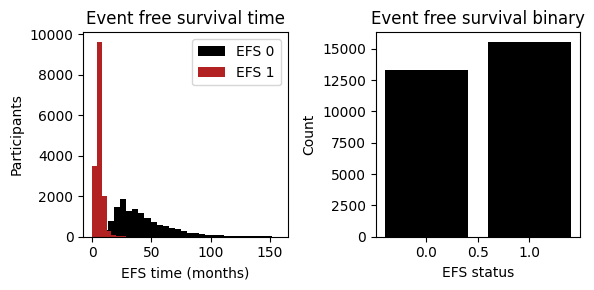

In [7]:
efs_neg_df=data_df[data_df['efs'] == 0]
efs_pos_df=data_df[data_df['efs'] == 1]

# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(6,3))
axs=axs.flatten()

axs[0].set_title('Event free survival time')
axs[0].hist(efs_neg_df['efs_time'], bins=30, color='black', label='EFS 0')
axs[0].hist(efs_pos_df['efs_time'], bins=30, color='firebrick', label='EFS 1')
axs[0].set_xlabel('EFS time (months)')
axs[0].set_ylabel('Participants')
axs[0].legend(loc='upper right')

axs[1].set_title('Event free survival binary')
axs[1].bar(data_df['efs'].value_counts().index, data_df['efs'].value_counts(), color='black')
axs[1].set_xlabel('EFS status')
axs[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 3. Features

### 3.1. Numerical features

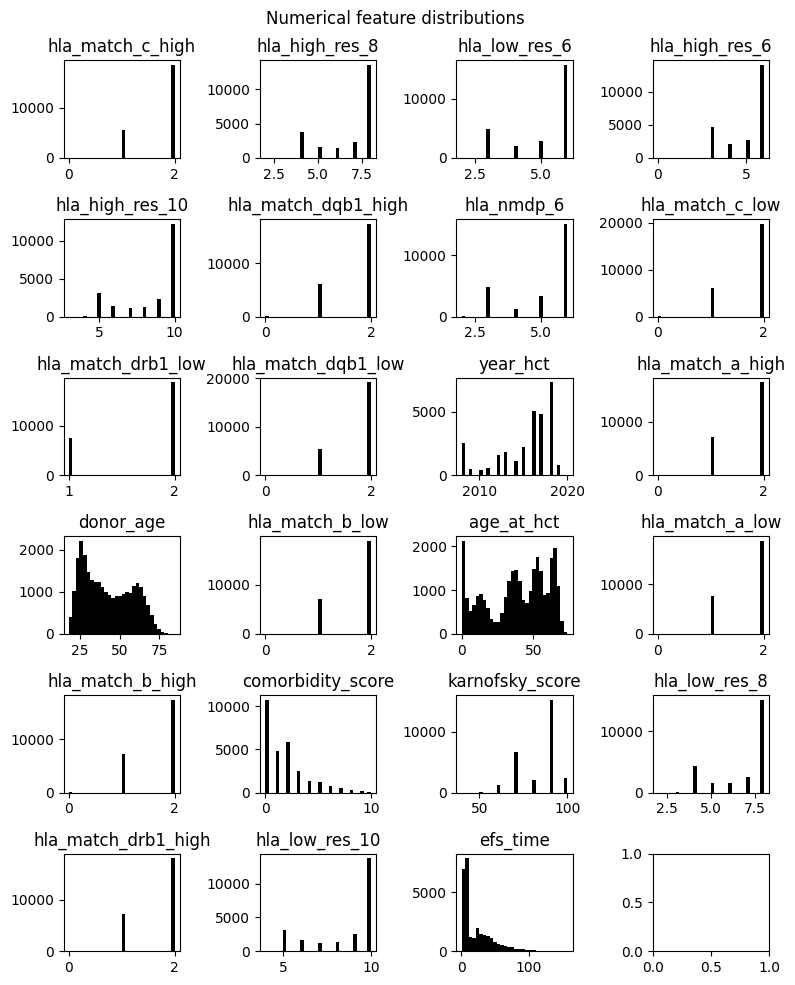

In [8]:
# Extract 'numerical' features as listed in the data dictionary
numerical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Numerical']
numerical_features_df=data_df[numerical_feature_names]

# Set-up a 5x5 figure
fig, axs=plt.subplots(6,4, figsize=(8,10))
axs=axs.flatten()

fig.suptitle('Numerical feature distributions')

# Plot each feature
for ax, feature in zip(axs, numerical_features_df.columns):
    ax.set_title(feature)
    ax.hist(numerical_features_df[feature], bins=30, color='black')

plt.tight_layout()
plt.show()

#### 3.2.1 Interval & ordinal 'numerical' features

In [9]:
interval_numerical_features=['donor_age', 'age_at_hct', 'year_hct', 'efs_time']
ordinal_numerical_features=[x for x in numerical_features_df.columns if x not in interval_numerical_features]

print(f'Interval features: {interval_numerical_features}\n')
print(f'Ordinal features: {ordinal_numerical_features}')

Interval features: ['donor_age', 'age_at_hct', 'year_hct', 'efs_time']

Ordinal features: ['hla_match_c_high', 'hla_high_res_8', 'hla_low_res_6', 'hla_high_res_6', 'hla_high_res_10', 'hla_match_dqb1_high', 'hla_nmdp_6', 'hla_match_c_low', 'hla_match_drb1_low', 'hla_match_dqb1_low', 'hla_match_a_high', 'hla_match_b_low', 'hla_match_a_low', 'hla_match_b_high', 'comorbidity_score', 'karnofsky_score', 'hla_low_res_8', 'hla_match_drb1_high', 'hla_low_res_10']


### 3.2. Categorical features

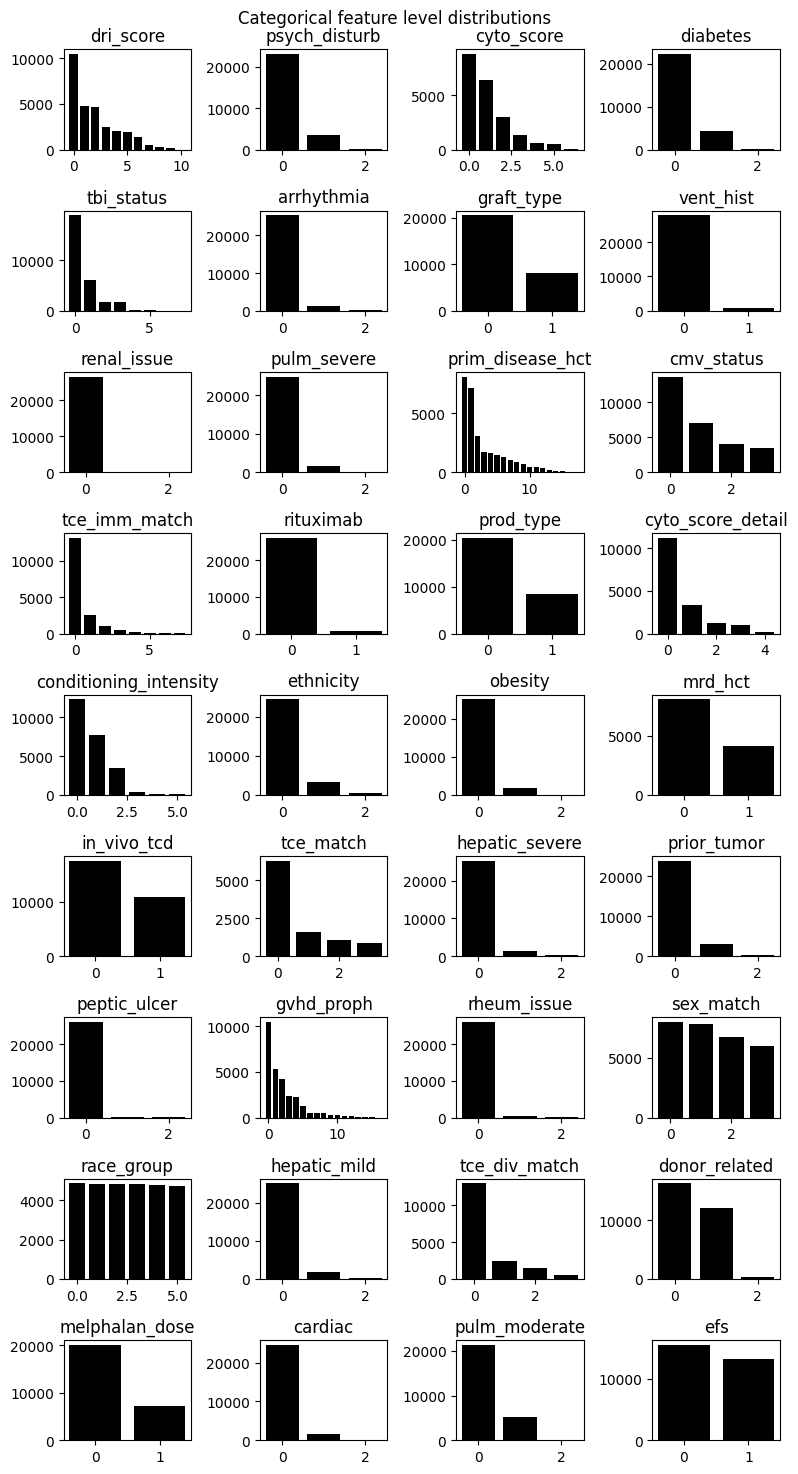

In [10]:
# Extract 'categorical' features as listed in the data dictionary
categorical_feature_names=dictionary_df['variable'][dictionary_df['type'] == 'Categorical']
categorical_features_df=data_df[categorical_feature_names]

# Set-up a 5x5 figure
fig, axs=plt.subplots(9,4, figsize=(8,15))
axs=axs.flatten()

fig.suptitle('Categorical feature level distributions')

# Plot each feature
for ax, feature in zip(axs, categorical_features_df.columns):
    level_counts=categorical_features_df[feature].value_counts()
    ax.set_title(feature)
    ax.bar(list(range(len(level_counts.index))), level_counts.values, color='black')

plt.tight_layout()
plt.show()

#### 3.2.1. Ordinal & nominal 'categorical' features

In [11]:
ordinal_categorical_features=['dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']
nominal_categorical_features=[x for x in categorical_features_df.columns if x not in ordinal_categorical_features]
print(f'Ordinal categorical features: {ordinal_categorical_features}\n')
print(f'True categorical features: {nominal_categorical_features}\n')

Ordinal categorical features: ['dri_score', 'cyto_score', 'cmv_status', 'cyto_score_detail']

True categorical features: ['psych_disturb', 'diabetes', 'tbi_status', 'arrhythmia', 'graft_type', 'vent_hist', 'renal_issue', 'pulm_severe', 'prim_disease_hct', 'tce_imm_match', 'rituximab', 'prod_type', 'conditioning_intensity', 'ethnicity', 'obesity', 'mrd_hct', 'in_vivo_tcd', 'tce_match', 'hepatic_severe', 'prior_tumor', 'peptic_ulcer', 'gvhd_proph', 'rheum_issue', 'sex_match', 'race_group', 'hepatic_mild', 'tce_div_match', 'donor_related', 'melphalan_dose', 'cardiac', 'pulm_moderate', 'efs']



##### 3.2.1.1. DRI score

In [12]:
categorical_features_df['dri_score'].value_counts()

dri_score
Intermediate                                         10436
N/A - pediatric                                       4779
High                                                  4701
N/A - non-malignant indication                        2427
TBD cytogenetics                                      2003
Low                                                   1926
High - TED AML case <missing cytogenetics             1414
Intermediate - TED AML case <missing cytogenetics      481
N/A - disease not classifiable                         272
Very high                                              198
Missing disease status                                   9
Name: count, dtype: int64

In [13]:
dri_scores={
    'Intermediate': '2',
    'N/A - pediatric': '0',
    'High': '4',
    'N/A - non-malignant indication': '0',
    'TBD cytogenetics': np.nan,
    'Low': '1',
    'High - TED AML case <missing cytogenetics': '4',
    'Intermediate - TED AML case <missing cytogenetics': '3',
    'N/A - disease not classifiable': np.nan,
    'Very high': '5',
    'Missing disease status': np.nan
}

##### 3.2.1.2. Cyto score

In [14]:
categorical_features_df['cyto_score'].value_counts()

cyto_score
Poor            8802
Intermediate    6376
Favorable       3011
TBD             1341
Normal           643
Other            504
Not tested        55
Name: count, dtype: int64

In [15]:
cyto_scores={
    'Poor': '4',
    'Intermediate': '3', 
    'Favorable': '1',
    'TBD': np.nan,
    'Normal': '2',
    'Other': '0',
    'Not tested': np.nan  
}

##### 3.2.1.3. CMV status

In [16]:
categorical_features_df['cmv_status'].value_counts()

cmv_status
+/+    13596
-/+     7081
+/-     4048
-/-     3441
Name: count, dtype: int64

In [17]:
cmv_statuses={
    '+/+': '3',
    '-/+': '1',
    '+/-': '1',
    '-/-': '0'
}

##### 3.2.1.4. Cyto score detail

In [18]:
categorical_features_df['cyto_score_detail'].value_counts()

cyto_score_detail
Intermediate    11158
Poor             3323
Favorable        1208
TBD              1043
Not tested        145
Name: count, dtype: int64

In [19]:
cyto_scores_detail={
    'Intermediate': '1',
    'Poor': '2',
    'Favorable': '0',
    'TBD': np.nan,
    'Not tested': np.nan
}

##### 3.2.1.5. Graft type

In [20]:
categorical_features_df['graft_type'].value_counts()

graft_type
Peripheral blood    20546
Bone marrow          8254
Name: count, dtype: int64

In [21]:
graft_type={
    'Peripheral blood': 'Blood',
    'Bone marrow': 'Marrow',
    'Favorable': '0'
}

##### 3.2.1.6. Prim disease hct

In [22]:
categorical_features_df['prim_disease_hct'].value_counts()

prim_disease_hct
ALL                     8102
AML                     7135
MDS                     3046
IPA                     1719
MPN                     1656
IEA                     1449
NHL                     1319
IIS                     1024
PCD                      869
SAA                      713
AI                       449
HIS                      445
Other leukemia           366
Solid tumor              207
IMD                      144
Other acute leukemia      83
HD                        54
CML                       20
Name: count, dtype: int64

In [23]:
prim_disease_hct={
    'Other leukemia': 'LEU',
    'Solid tumor': 'SOL',
    'Other acute leukemia': 'ALEU'
}

##### 3.2.1.7. Gvhd proph

In [24]:
categorical_features_df['gvhd_proph'].value_counts()

gvhd_proph
FK+ MMF +- others                  10440
Cyclophosphamide alone              5270
FK+ MTX +- others(not MMF)          4262
Cyclophosphamide +- others          2369
CSA + MMF +- others(not FK)         2278
FKalone                             1230
Other GVHD Prophylaxis               550
TDEPLETION alone                     545
TDEPLETION +- other                  539
No GvHD Prophylaxis                  262
CDselect alone                       251
CSA + MTX +- others(not MMF,FK)      224
CSA alone                            214
Parent Q = yes, but no agent          62
CDselect +- other                     55
CSA +- others(not FK,MMF,MTX)         23
FK+- others(not MMF,MTX)               1
Name: count, dtype: int64

In [25]:
gvhd_proph={
    'FK+ MMF +- others': 'FK+MMF',
    'Cyclophosphamide alone': 'Cyclop',
    'FK+ MTX +- others(not MMF)': 'FK+MTX',
    'Cyclophosphamide +- others': 'Cyclop+',
    'CSA + MMF +- others(not FK)': 'CSA+MMF',
    'FKalone': 'FK',
    'Other GVHD Prophylaxis': 'GVHD',
    'TDEPLETION alone': 'T-DEP',
    'TDEPLETION +- other': 'T-DEP+',
    'No GvHD Prophylaxis': 'None',
    'CDselect alone': 'CDsel',
    'CSA + MTX +- others(not MMF,FK)': 'CSA+MTX+',
    'CSA alone': 'CSA',
    'Parent Q = yes, but no agent': 'ParQ',
    'CDselect +- other': 'CDsel+',
    'CSA +- others(not FK,MMF,MTX)': 'CSA+',
    'FK+- others(not MMF,MTX)': 'FK+'
}

##### 3.2.1.8. Conditioning intensity

In [26]:
categorical_features_df['conditioning_intensity'].value_counts()

conditioning_intensity
MAC                              12288
RIC                               7722
NMA                               3479
TBD                                373
No drugs reported                   87
N/A, F(pre-TED) not submitted       62
Name: count, dtype: int64

In [27]:
conditioning_intensity={
    'No drugs reported': 'None',
    'N/A, F(pre-TED) not submitted': np.nan
}

##### 3.2.1.9. Race group

In [28]:
categorical_features_df['race_group'].value_counts()

race_group
More than one race                           4845
Asian                                        4832
White                                        4831
Black or African-American                    4795
American Indian or Alaska Native             4790
Native Hawaiian or other Pacific Islander    4707
Name: count, dtype: int64

In [29]:
race_group={
    'More than one race': 'Mult.',
    'Black or African-American': 'Afro-Amer',
    'American Indian or Alaska Native': 'Nat. Amer.',
    'Native Hawaiian or other Pacific Islander': 'Pac. Isl.'
}

##### 3.2.1.10. TBI status

In [30]:
categorical_features_df['tbi_status'].value_counts()

tbi_status
No TBI                              18861
TBI + Cy +- Other                    6104
TBI +- Other, <=cGy                  1727
TBI +- Other, >cGy                   1700
TBI +- Other, -cGy, single            134
TBI +- Other, -cGy, fractionated      119
TBI +- Other, -cGy, unknown dose       79
TBI +- Other, unknown dose             76
Name: count, dtype: int64

In [31]:
tbi_status={
    'No TBI': 'None',
    'TBI + Cy +- Other': 'Cy',
    'TBI +- Other, <=cGy': '<=cGy',
    'TBI +- Other, >cGy': '>cGy',
    'TBI +- Other, -cGy, single': 'single',
    'TBI +- Other, -cGy, fractionated': 'frac',
    'TBI +- Other, -cGy, unknown dose': 'unknown',
    'TBI +- Other, unknown dose': np.nan
}

##### 3.2.1.11. Ethnicity

In [32]:
categorical_features_df['ethnicity'].value_counts()

ethnicity
Not Hispanic or Latino      24482
Hispanic or Latino           3347
Non-resident of the U.S.      384
Name: count, dtype: int64

In [33]:
ethnicity={
    'Not Hispanic or Latino': '-His+Lat',
    'Hispanic or Latino': '+His+Lat',
    'Non-resident of the U.S.': 'Non-US'
}

##### 3.2.1.12. TCE match

In [34]:
categorical_features_df['tce_match'].value_counts()

tce_match
Permissive            6272
GvH non-permissive    1605
Fully matched         1059
HvG non-permissive     868
Name: count, dtype: int64

In [35]:
tce_match={
    'Permissive': 'Per',
    'GvH non-permissive': 'GvH non-per',
    'Fully matched': 'Match',
    'HvG non-permissive': 'HvG non-per'
}

##### 3.2.1.13. Donor related

In [36]:
categorical_features_df['donor_related'].value_counts()

donor_related
Related                     16208
Unrelated                   12088
Multiple donor (non-UCB)      346
Name: count, dtype: int64

In [37]:
donor_related={
    'Related': 'Yes',
    'Unrelated': 'No',
    'Multiple donor (non-UCB)': 'Multi.'
}

##### 3.2.1.14. Donor related

In [38]:
categorical_features_df['tce_div_match'].value_counts()

tce_div_match
Permissive mismatched            12936
GvH non-permissive                2458
HvG non-permissive                1417
Bi-directional non-permissive      593
Name: count, dtype: int64

In [39]:
tce_div_match={
    'Permissive mismatched': 'Yes',
    'GvH non-permissive': 'GvH no',
    'HvG non-permissive': 'HvG no',
    'Bi-directional non-permissive': 'No'
}

##### 3.2.1.15. Melphalan dose

In [40]:
categorical_features_df['melphalan_dose'].value_counts()

melphalan_dose
N/A, Mel not given    20135
MEL                    7260
Name: count, dtype: int64

In [41]:
melphalan_dose={
    'N/A, Mel not given': 'No',
    'MEL': 'Yes'
}

### 3.3. Feature definition dictionaries

In [42]:
interval_numerical_features.remove('efs_time')
nominal_categorical_features.remove('efs')

feature_types={
    'Interval': interval_numerical_features,
    'Ordinal': ordinal_numerical_features + ordinal_categorical_features,
    'Nominal': nominal_categorical_features,
    'Labels': ['efs', 'efs_time']
}

with open(feature_types_dict_file, 'wb') as output_file:
    pickle.dump(feature_types, output_file)

feature_value_translation_dicts={
    'dri_score': dri_scores,
    'cyto_score': cyto_scores,
    'cmv_status': cmv_statuses,
    'cyto_score_detail': cyto_scores_detail,
    'graft_type': graft_type,
    'prim_disease_hct': prim_disease_hct,
    'gvhd_proph': gvhd_proph,
    'conditioning_intensity': conditioning_intensity,
    'race_group': race_group,
    'tbi_status': tbi_status,
    'ethnicity': ethnicity,
    'tce_match': tce_match,
    'donor_related': donor_related,
    'tce_div_match': tce_div_match,
    'melphalan_dose': melphalan_dose
}

with open(feature_value_translation_dicts_file, 'wb') as output_file:
    pickle.dump(feature_value_translation_dicts, output_file)

## 4. Missing values

### 4.1. Missing value placeholders

In [43]:
missing_values={
    'Not done': np.nan,
    'TBD': np.nan,
    'Not tested': np.nan,
    'N/A': np.nan
}

with open(nan_placeholders_dict_file, 'wb') as output_file:
    pickle.dump(missing_values, output_file)

### 4.2. NAN distribution

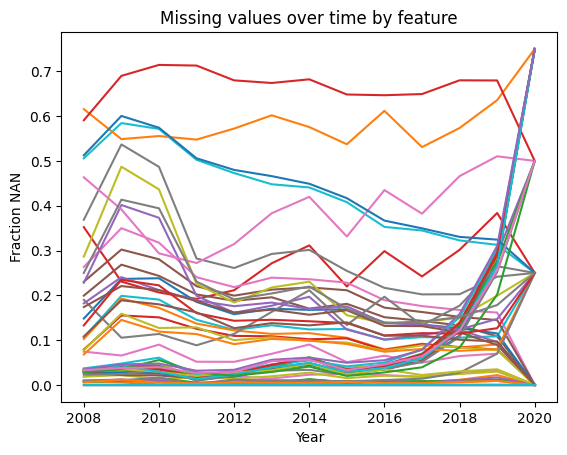

In [44]:
nan_counts=data_df.groupby('year_hct')[data_df.columns].apply(lambda x: x.isna().sum())
row_counts=data_df.groupby('year_hct')[data_df.columns].apply(lambda x: len(x))

plt.title('Missing values over time by feature')

for feature in nan_counts.columns:
    plt.plot(row_counts.index, nan_counts[feature]/row_counts)

plt.xlabel('Year')
plt.ylabel('Fraction NAN')
plt.show()

## 5. Basic data cleaning

### 5.1. Feature value translation

In [45]:
for feature, translation_dict in feature_value_translation_dicts.items():
    data_df[feature]=data_df[feature].replace(translation_dict)

### 5.2. NAN placeholder replacement

In [46]:
data_df.replace(missing_values, inplace=True)
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               26362 non-null  object 
 2   psych_disturb           26592 non-null  object 
 3   cyto_score              19336 non-null  object 
 4   diabetes                26540 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28724 non-null  object 
 8   arrhythmia              26480 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26748 non-null  object 
 13  pulm_severe             26485 non-null  object 
 14  prim_disease_hct        28800 non-null

## 6. Feature-label interactions

### 6.1. Nominal features

#### 6.1.1. EFS binary: chi-squared test

In [ ]:
total_efs_pos=sum(data_df['efs'])
total_efs_frac=total_efs_pos / len(data_df)

chisquare_results={
    'Feature': [],
    'p-value': []
}

count_results={
    'Feature':[],
    'Level':[],
    'EFS':[],
    'Count': []
}

for feature in feature_types['Nominal']:

    groups=data_df.groupby(feature)['efs']

    observed_counts=[]
    expected_counts=[]

    for group, group_efs in groups:
        group_participants=len(group_efs)
        observed_group_efs_pos=sum(group_efs)
        observed_group_efs_neg=len(group_efs) - observed_group_efs_pos
        expected_group_efs_pos=round(len(group_efs) * total_efs_frac, 0)
        expected_group_efs_neg=len(group_efs) - expected_group_efs_pos

        if expected_group_efs_pos != 0 and expected_group_efs_neg != 0:
            observed_counts.extend([observed_group_efs_pos, observed_group_efs_neg])
            expected_counts.extend([expected_group_efs_pos, expected_group_efs_neg])

            count_results['Feature'].append(feature)
            count_results['Level'].append(group)
            count_results['EFS'].append('Zero')
            count_results['Count'].append(observed_group_efs_neg)

            count_results['Feature'].append(feature)
            count_results['Level'].append(group)
            count_results['EFS'].append('One')
            count_results['Count'].append(observed_group_efs_pos)

        elif observed_group_efs_pos == 0 or observed_group_efs_neg == 0:
            print(f'Empty category in {feature}, {group}: EFS pos={observed_group_efs_pos}, EFS neg={observed_group_efs_neg}')

    chisquare_result=chisquare(f_obs=observed_counts, f_exp=expected_counts)

    chisquare_results['Feature'].append(feature)
    chisquare_results['p-value'].append(chisquare_result.pvalue)

count_results_df=pd.DataFrame.from_dict(count_results)
chisquare_results_df=pd.DataFrame.from_dict(chisquare_results)
chisquare_results_df.sort_values('p-value', inplace=True)
chisquare_results_df.reset_index(inplace=True, drop=True)

Empty category in gvhd_proph, FK+: EFS pos=1.0, EFS neg=0.0


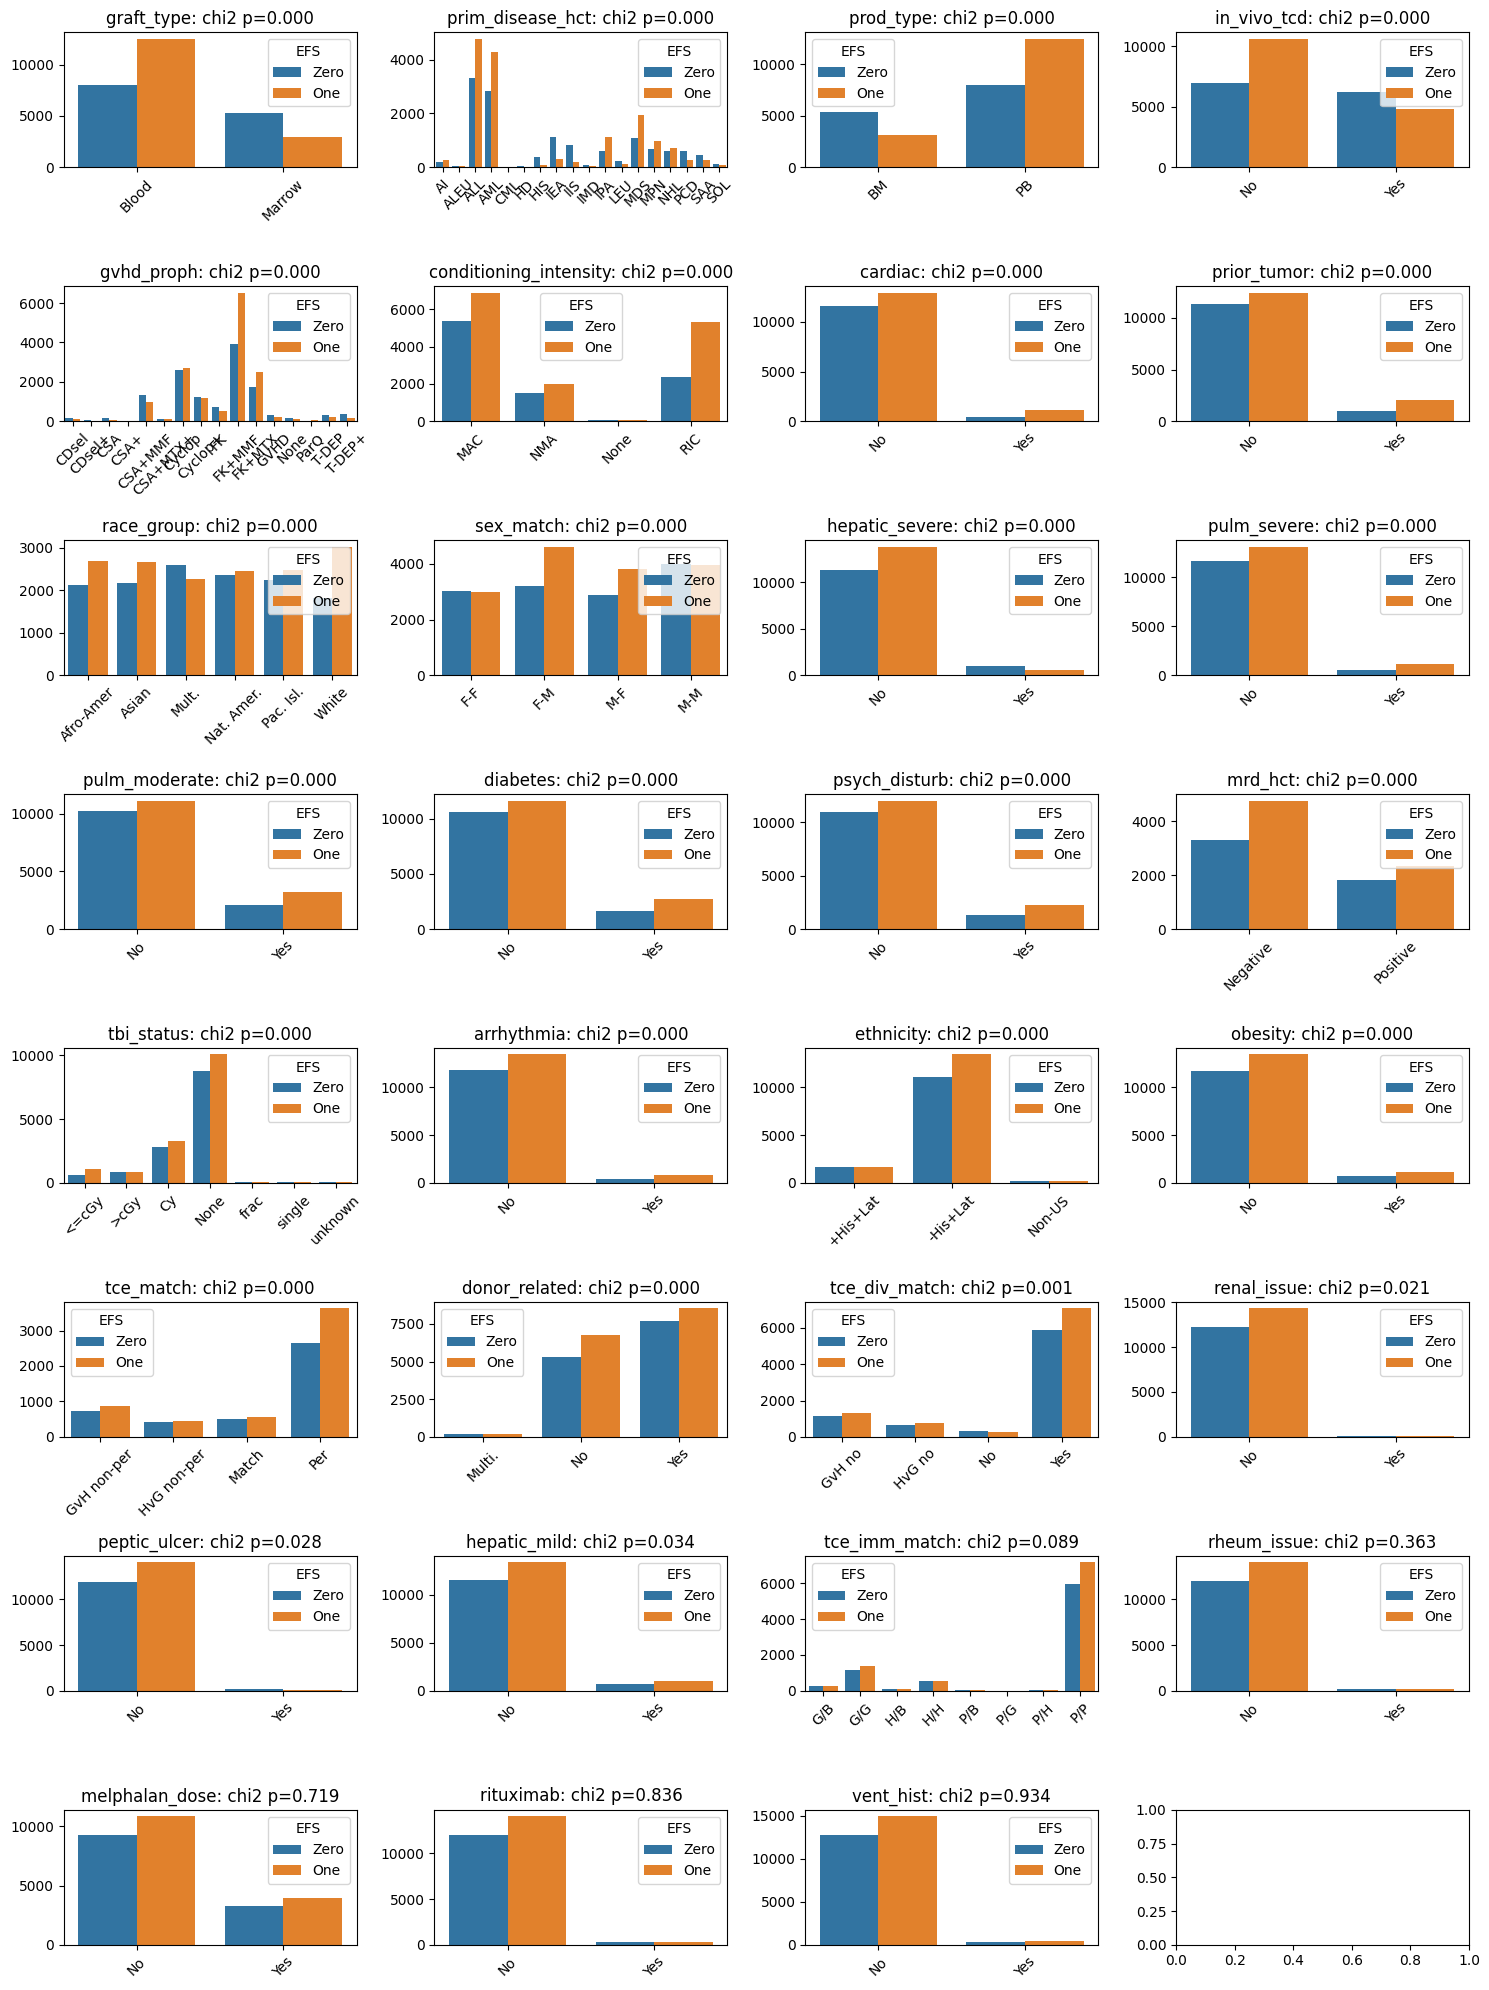

In [48]:
plot_cols=4
plot_rows=int(len(chisquare_results_df)/plot_cols) + 1

fig, axs=plt.subplots(plot_rows, plot_cols, figsize=(15,plot_rows*2.5))
axs=axs.flatten()

for i, row in chisquare_results_df.iterrows():
    plot_df=count_results_df[count_results_df['Feature'] == row['Feature']]
    sns.barplot(plot_df, x='Level', y='Count', hue='EFS', ax=axs[i])
    axs[i].set_title(f"{row['Feature']}: chi2 p={row['p-value']:.3f}")
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.tight_layout()
fig.show()

#### 6.1.2. EFS time: Kruskal-Willis test

In [49]:
kruskal_results={
    'Feature':[],
    'p-value':[]
}

for feature in feature_types['Nominal']:

    groups=data_df.groupby(feature)['efs_time']
    efs_times=[list(group_efs_times) for _, group_efs_times in groups]
    kruskal_result=kruskal(*efs_times)
    kruskal_results['Feature'].append(feature)
    kruskal_results['p-value'].append(kruskal_result.pvalue)

kruskal_results_df=pd.DataFrame.from_dict(kruskal_results)
kruskal_results_df.sort_values('p-value', inplace=True)
kruskal_results_df.reset_index(inplace=True, drop=True)

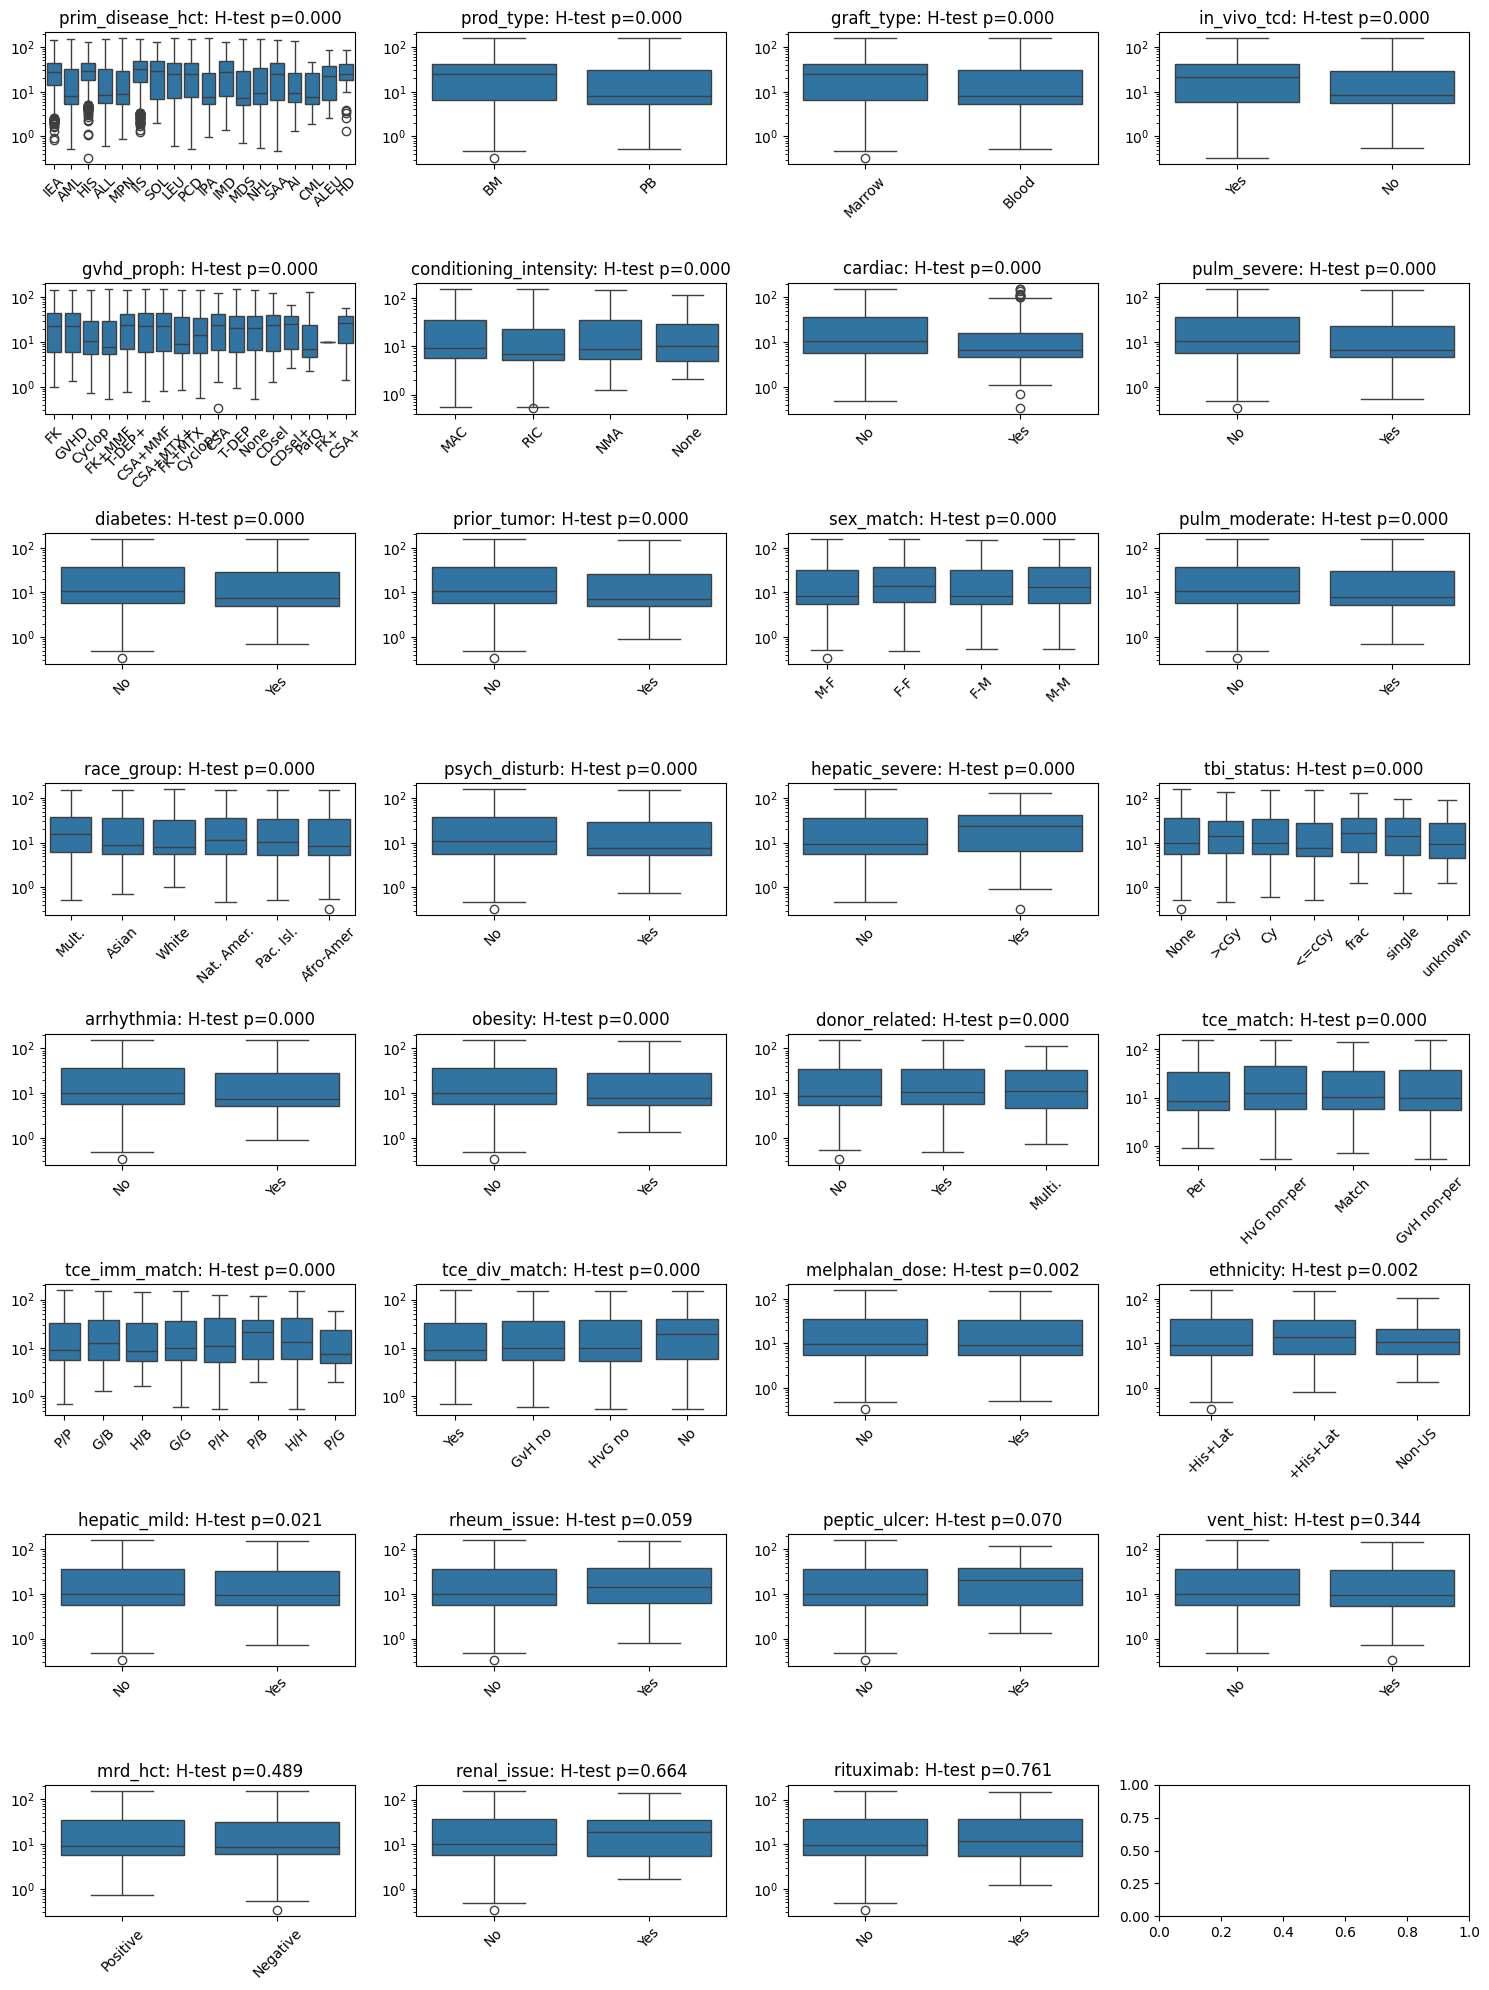

In [50]:
plot_cols=4
plot_rows=int(len(chisquare_results_df)/plot_cols) + 1

fig, axs=plt.subplots(plot_rows, plot_cols, figsize=(15,plot_rows*2.5))
axs=axs.flatten()

for i, row in kruskal_results_df.iterrows():
    sns.boxplot(data_df, x=row['Feature'], y='efs_time', ax=axs[i], log_scale=True)
    axs[i].set_title(f"{row['Feature']}: H-test p={row['p-value']:.3f}")
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.tight_layout()

### 6.2. Ordinal features

#### 6.2.1. EFS binary: chi-squared test

In [51]:
total_efs_pos=sum(data_df['efs'])
total_efs_frac=total_efs_pos / len(data_df)

chisquare_results={
    'Feature': [],
    'p-value': []
}

count_results={
    'Feature':[],
    'Level':[],
    'EFS':[],
    'Count': []
}

for feature in feature_types['Ordinal']:

    groups=data_df.groupby(feature)['efs']

    observed_counts=[]
    expected_counts=[]

    for group, group_efs in groups:
        group_participants=len(group_efs)
        observed_group_efs_pos=sum(group_efs)
        observed_group_efs_neg=len(group_efs) - observed_group_efs_pos
        expected_group_efs_pos=round(len(group_efs) * total_efs_frac, 0)
        expected_group_efs_neg=len(group_efs) - expected_group_efs_pos

        if expected_group_efs_pos != 0 and expected_group_efs_neg != 0:
            observed_counts.extend([observed_group_efs_pos, observed_group_efs_neg])
            expected_counts.extend([expected_group_efs_pos, expected_group_efs_neg])

            count_results['Feature'].append(feature)
            count_results['Level'].append(group)
            count_results['EFS'].append('Zero')
            count_results['Count'].append(observed_group_efs_neg)

            count_results['Feature'].append(feature)
            count_results['Level'].append(group)
            count_results['EFS'].append('One')
            count_results['Count'].append(observed_group_efs_pos)

        elif observed_group_efs_pos == 0 or observed_group_efs_neg == 0:
            print(f'Empty category in {feature}, {group}: EFS pos={observed_group_efs_pos}, EFS neg={observed_group_efs_neg}')

    chisquare_result=chisquare(f_obs=observed_counts, f_exp=expected_counts)

    chisquare_results['Feature'].append(feature)
    chisquare_results['p-value'].append(chisquare_result.pvalue)

count_results_df=pd.DataFrame.from_dict(count_results)
chisquare_results_df=pd.DataFrame.from_dict(chisquare_results)
chisquare_results_df.sort_values('p-value', inplace=True)
chisquare_results_df.reset_index(inplace=True, drop=True)

Empty category in hla_high_res_6, 0.0: EFS pos=0.0, EFS neg=1.0
Empty category in hla_high_res_10, 3.0: EFS pos=0.0, EFS neg=1.0
Empty category in hla_low_res_8, 2.0: EFS pos=1.0, EFS neg=0.0


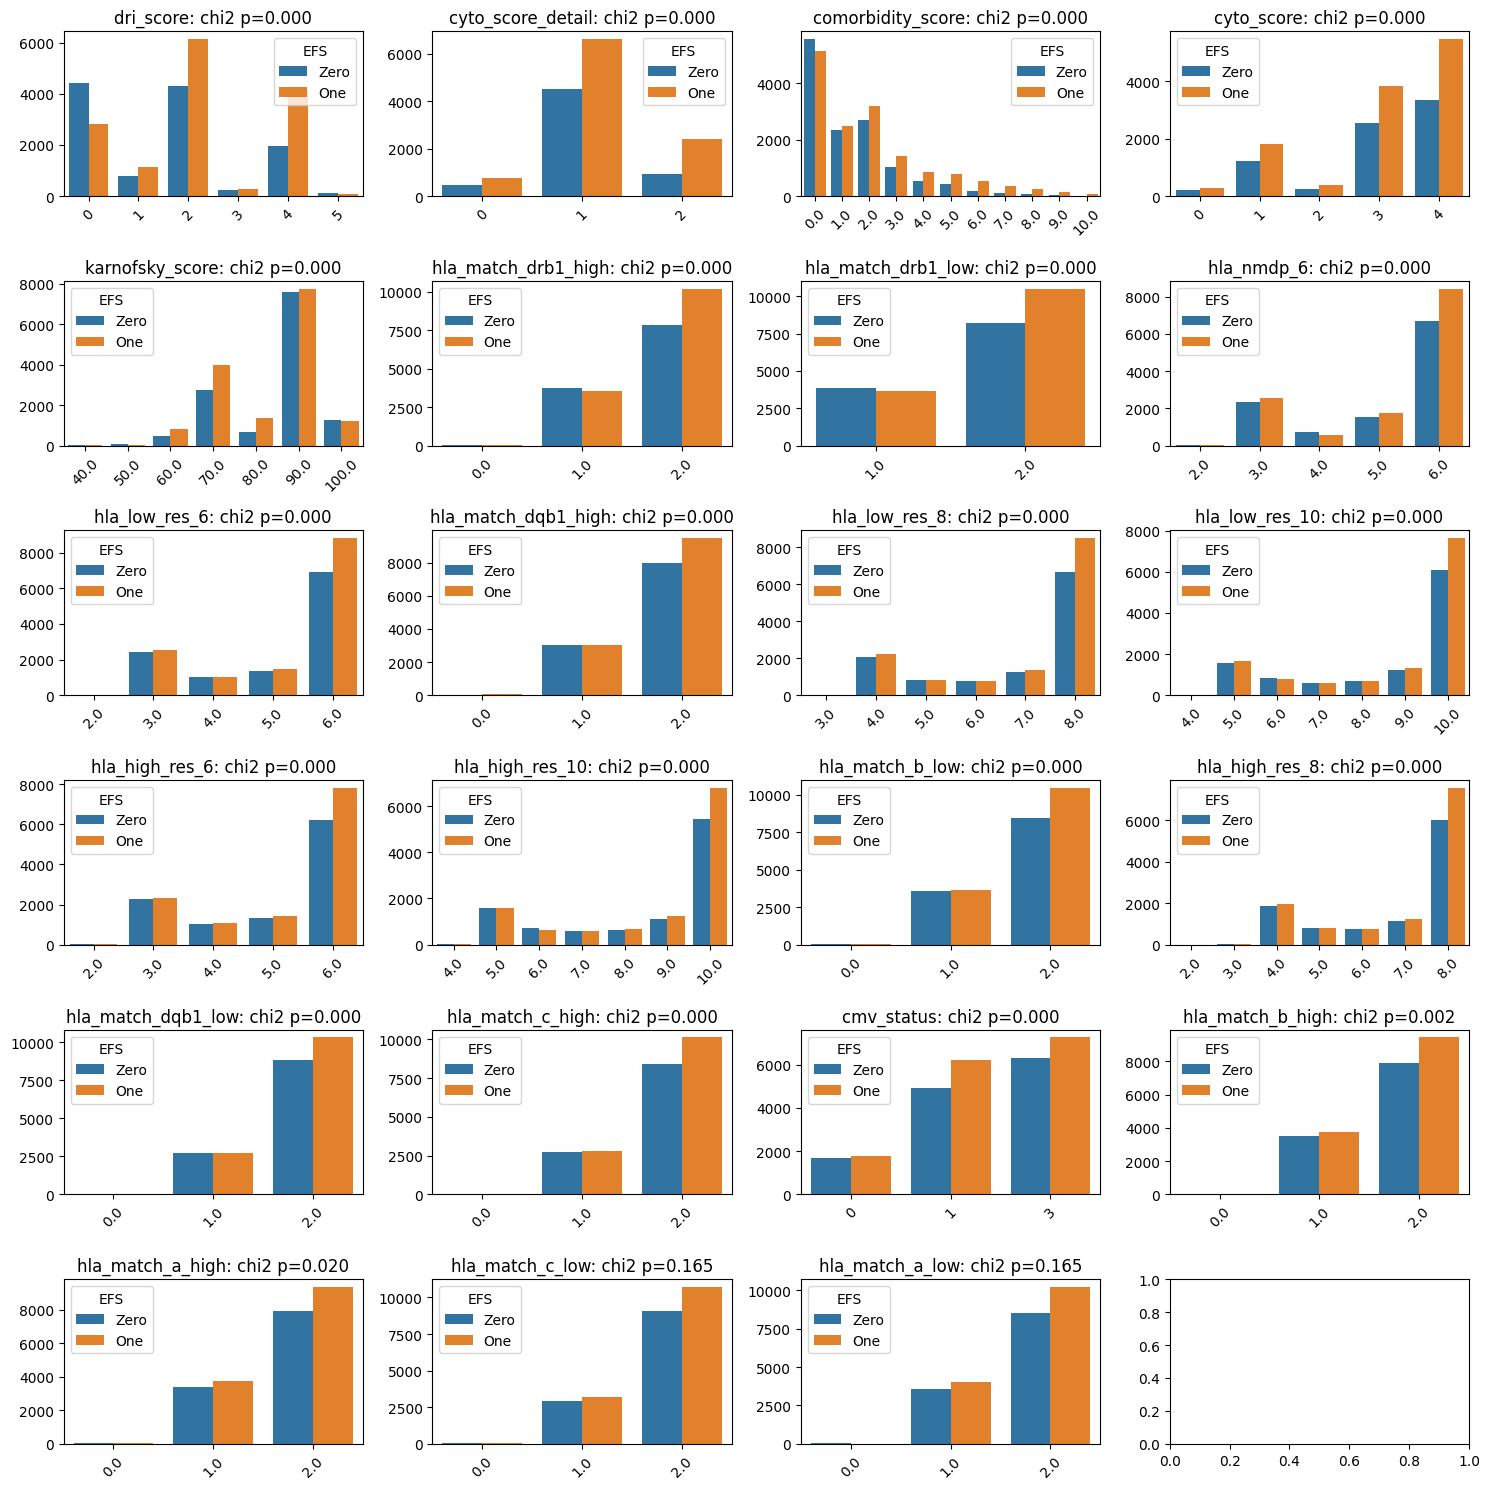

In [52]:
plot_cols=4
plot_rows=int(len(chisquare_results_df)/plot_cols) + 1

fig, axs=plt.subplots(plot_rows, plot_cols, figsize=(15,plot_rows*2.5))
axs=axs.flatten()

for i, row in chisquare_results_df.iterrows():
    plot_df=count_results_df[count_results_df['Feature'] == row['Feature']]
    sns.barplot(plot_df, x='Level', y='Count', hue='EFS', ax=axs[i])
    axs[i].set_title(f"{row['Feature']}: chi2 p={row['p-value']:.3f}")
    axs[i].tick_params(axis='x', labelrotation=45)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.tight_layout()
fig.show()

#### 6.2.2. EFS time: Kruskal-Willis test

In [53]:
kruskal_results={
    'Feature':[],
    'p-value':[]
}

for feature in feature_types['Ordinal']:

    groups=data_df.groupby(feature)['efs_time']
    efs_times=[list(group_efs_times) for _, group_efs_times in groups]
    kruskal_result=kruskal(*efs_times)
    kruskal_results['Feature'].append(feature)
    kruskal_results['p-value'].append(kruskal_result.pvalue)

kruskal_results_df=pd.DataFrame.from_dict(kruskal_results)
kruskal_results_df.sort_values('p-value', inplace=True)
kruskal_results_df.reset_index(inplace=True, drop=True)

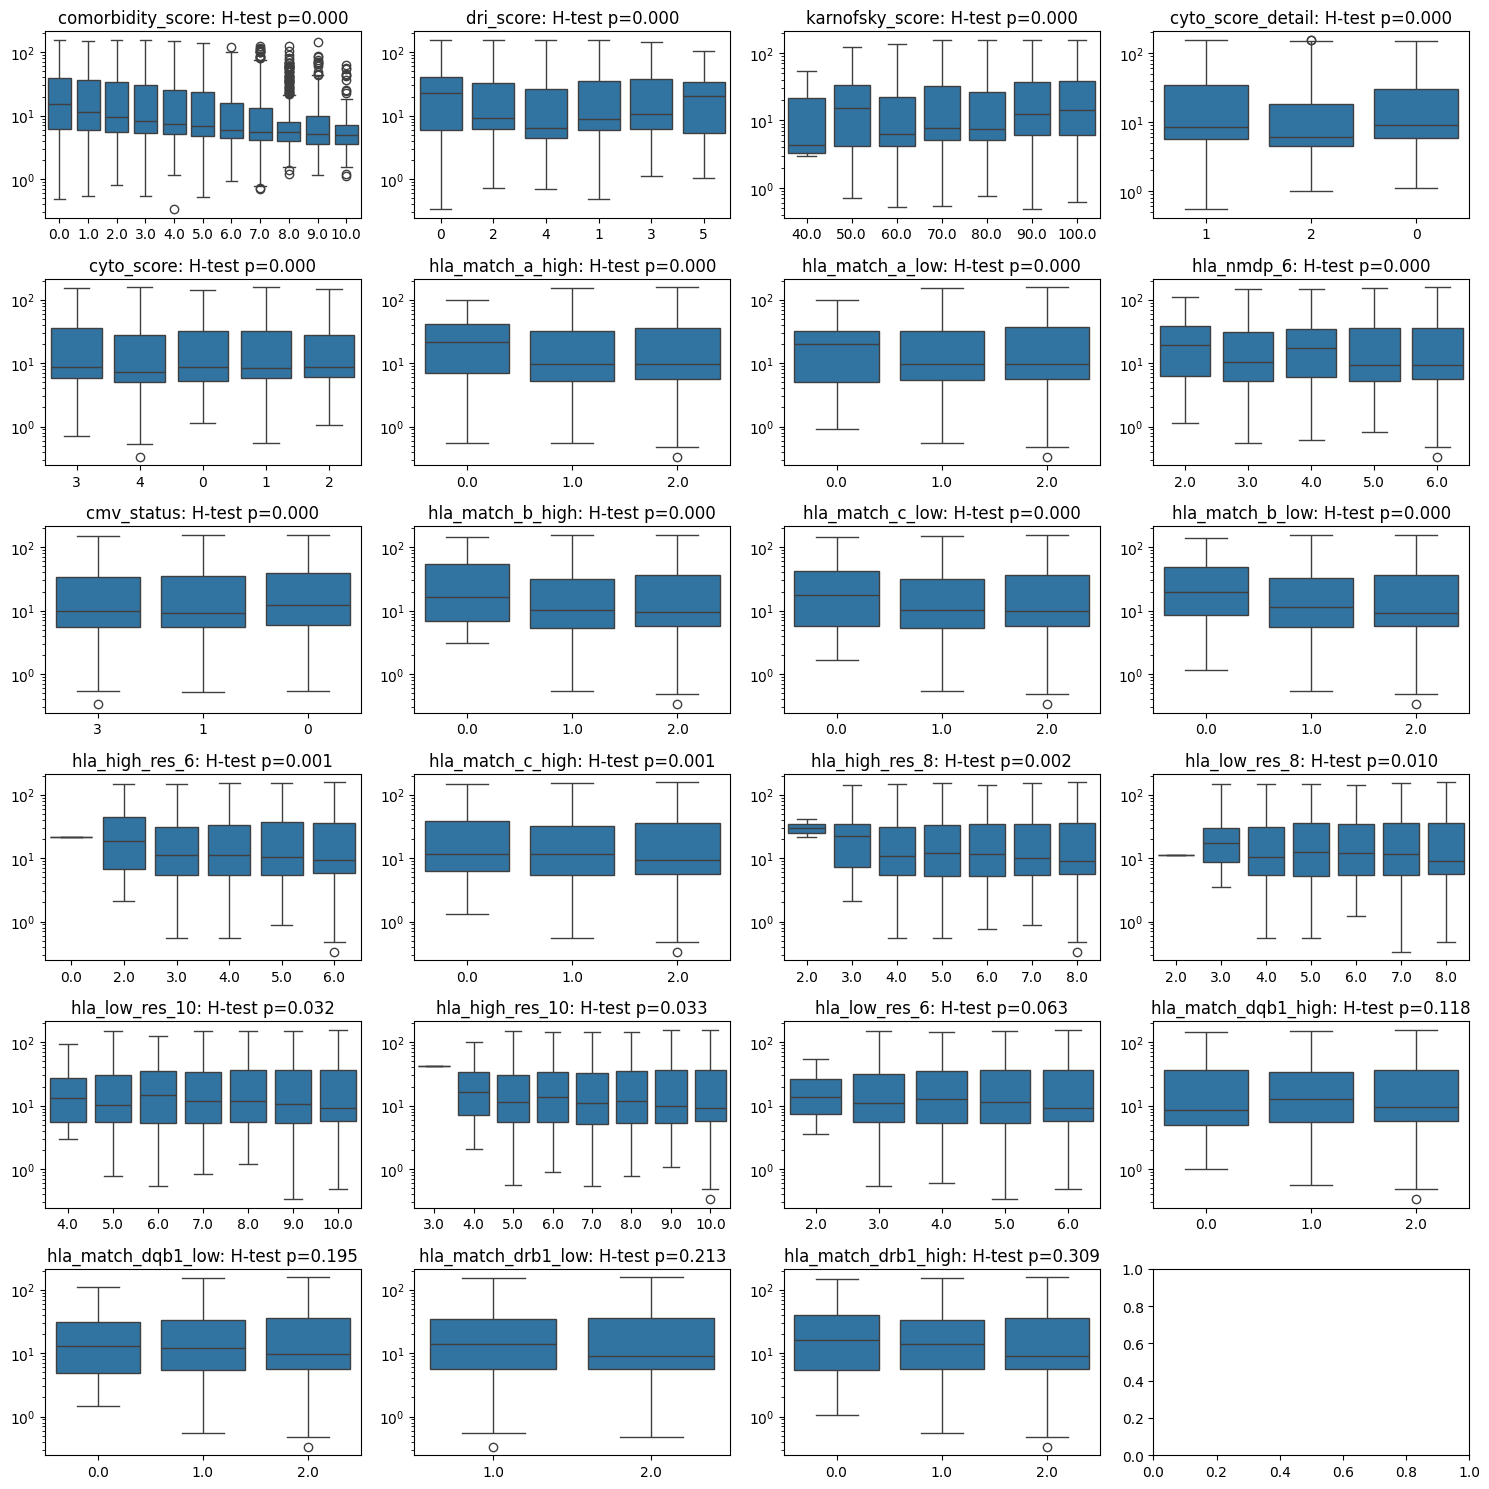

In [73]:
plot_cols=4
plot_rows=int(len(chisquare_results_df)/plot_cols) + 1

fig, axs=plt.subplots(plot_rows, plot_cols, figsize=(15,plot_rows*2.5))
axs=axs.flatten()

for i, row in kruskal_results_df.iterrows():
    sns.boxplot(data_df, x=row['Feature'], y='efs_time', ax=axs[i], log_scale=True)
    axs[i].set_title(f"{row['Feature']}: H-test p={row['p-value']:.3f}")
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

fig.tight_layout()

### 6.3. Interval features

#### 6.3.1. EFS binary: Mann-Whitney U test

In [ ]:
efs_pos_df=data_df[data_df['efs'] == 1]
efs_neg_df=data_df[data_df['efs'] == 0]

mann_results={
    'Feature': [],
    'p-value': []
}

for feature in feature_types['Interval'] + ['efs_time']:
    mann_result=mannwhitneyu(efs_pos_df[feature], efs_neg_df[feature], nan_policy='omit')
    mann_results['Feature'].append(feature)
    mann_results['p-value'].append(mann_result.pvalue)

mann_results_df=pd.DataFrame.from_dict(mann_results)
mann_results_df.sort_values('p-value', inplace=True, ascending=True)
mann_results_df.reset_index(inplace=True, drop=True)

,Feature,p-value
0,efs_time,0.000000e+00
1,age_at_hct,1.504411e-295
2,year_hct,1.492950e-79
3,donor_age,4.514176e-13


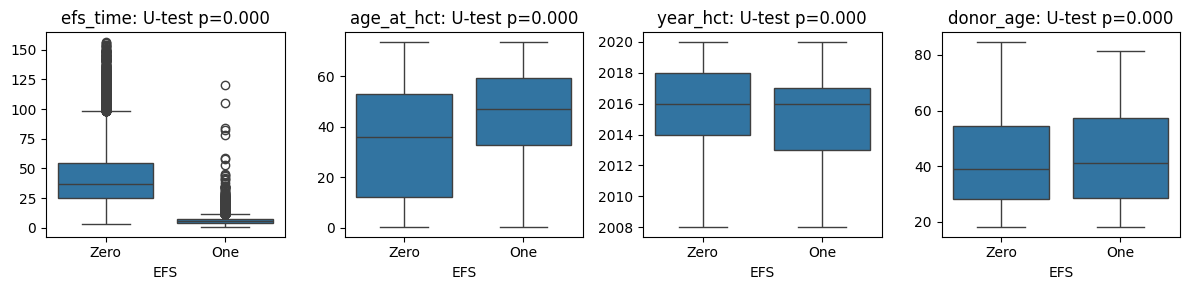

In [75]:
data_df['EFS']=data_df['efs'].replace({0: 'Zero', 1:'One'})
fig, axs=plt.subplots(1, 4, figsize=(12,3))
axs=axs.flatten()

for i, row in mann_results_df.iterrows():
    sns.boxplot(data_df, x='EFS', y=row['Feature'], ax=axs[i])
    axs[i].set_title(f"{row['Feature']}: U-test p={row['p-value']:.3f}")
    axs[i].set_xlabel('EFS')
    axs[i].set_ylabel('')

fig.tight_layout()

#### 6.3.2. EFS time: Spearman rank correlation

In [84]:
spearman_results={
    'Feature': [],
    'p-value': [],
    'rho': []
}

for feature in feature_types['Interval']:
    spearman_result=spearmanr(data_df['efs_time'], data_df[feature], nan_policy='omit')
    spearman_results['Feature'].append(feature)
    spearman_results['p-value'].append(spearman_result.pvalue)
    spearman_results['rho'].append(spearman_result.statistic)

spearman_results_df=pd.DataFrame.from_dict(spearman_results)
spearman_results_df.sort_values('rho', inplace=True, ascending=True)
spearman_results_df.reset_index(inplace=True, drop=True)
spearman_results_df.head()

,Feature,p-value,rho
0,age_at_hct,2.238721e-193,-0.173477
1,year_hct,2.651906e-105,-0.127900
2,donor_age,6.934973e-08,-0.032817


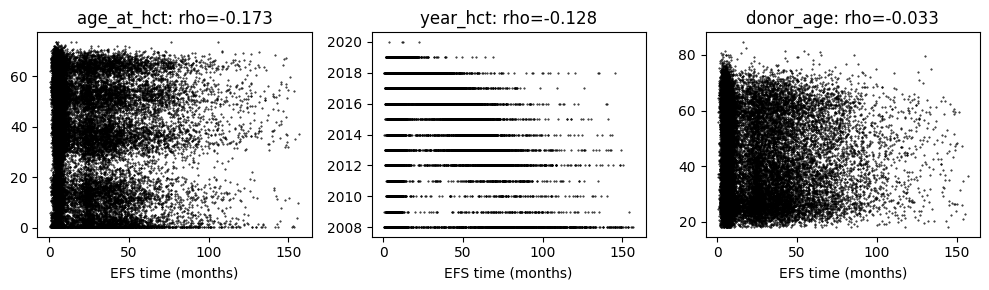

In [87]:
fig, axs=plt.subplots(1, 3, figsize=(10,3))
axs=axs.flatten()

for i, row in spearman_results_df.iterrows():
    axs[i].scatter(data_df['efs_time'], data_df[row['Feature']], color='black', s=0.2)
    axs[i].set_title(f"{row['Feature']}: rho={row['rho']:.3f}")
    axs[i].set_xlabel('EFS time (months)')
    axs[i].set_ylabel('')

fig.tight_layout()